<h3 align = 'center'> Comparison of Finding Exoplanets Using Traditional Methods and Machine Learning Models </h3>

<h3 align = 'center'> Abstract </h3> 

Planets found for an unkown Kepler system with the following periods 10.30398 ± 0.00089 days, 13.02492 ± 0.00027 days, 31.99544 ± 0.00013	days and 46.68559 ± 0.00099 days.

A convolutional neural network (CNN) and a recurrant neural network (RNN) developed to demonstrate the uses of machine learning in exoplanet detection trained on synthetic data, emphasize the difficulty with the applications of such a method. It will be presented that while there is difficulties in using a neural network for exoplanet detection, it deserves further exploration and a combination of a trained model with manual detection could prove benefital in exoplanet detection. 

The periods found by the CNN model were 24.907 days, 22.871 days abd 24.723 days these do not agree with the results found through traditional means. However the RNN model found periods of 1.306 days, 30.603 days and 45.611 days which is a bit more encouraging but still dwarfed by the percision of traditional methods.

The models were trained on synthetic data, and their performance was evaluated based on their ability to predict the number of planets and their corrosponding periods. The results that while the models predicted some values close to some periods, there were still large discrepancies in the number of planets detected and the periods assoicated with these. This highlights the challenges in using machine learning models for exoplanet detection, however it is hoped this report will show that machine learning for exoplanet detection is worthy of further research.

In [69]:
import TransitFinderFunctions as tff
import SyntheticLightCurveGeneration as syntheticLightCurve
import AnalyseModels as ml_prediction
import KeplerFunctions as kf
from IPython.display import Image

In [70]:
# If running on a low powered machine , or your just looking to see the code works, change this to True.
# Do note THE RESULTS WILL BE WORSE, but if you just want to see the code run set this to True.
# Some of the code here is computationally expensive, and I hope I have justified the computational expense in the report.
# But unless you got too much time on your hand, if you just want to see the code run set this to true
# I will attach a verssion of this notebook with everything ran in advance so you can see the good results. 

i_just_want_to_see_the_code_run = False

<h2 align="center">  1. Introduction: </h2>

</br>
<h3 align="center">  1.1 Finding Transits in an Unkown System </h3>

The challenge in finding transits in an unknown system lies in the need to sift through vast amounts of data to identify these sometimes subtle signals. Traditional methods rely on manual inspection or an algorithmic approach, but these methods can be insufficient for handling the large datasets generated by modern telescopes.

To address these challenges, machine learning models have been developed to automatically process and analyze large datasets, with the aim of identifying potential transits. By training models on known transit signals, machine learning algorithms can learn to recognise the patterns associated with exoplanetary transits.

In this report synthetic data will be created to train a model with the hope a trained model can identify the periods of the exoplanets of an unkown system from the Kepler high cadence dataset.


</br>
<h3 align="center">  1.2. The Current Context of Machine Learning in Exoplanet Detection  </h3>

The advent of machine learning for exoplanet detection is still in its infatncy. In 2017 Shallue, C.J. and Vanderburg, A. (2017) using a convolutional neural network discovered a new planet in Kepler 80, and a new planet in Kepler 90 . Other attempts have been made but with a succesrate less than deseriable of about 75% of planets found being false positives, but applicable to a larger dataset such as research done in Barbara, N.H., Bedding, T.R., Fulcher, B.D., Murphy, S.J. and Van Reeth, T. (2022).

A major issue with current applications of machine learning is the lack of training data. In this report an alternative to fill this training data void with synthetic data will be presented

</br>
<h3 align="center"> 1.3. Modelling Exoplanerty Transits </h3>

When creating synthetic lightcurves a balance needs to be found between percision and computational efficiency. Models such as Exoplanet by Foreman-Mackey, D., (2021) while incredibly percise in their measurements are not as computationally efficient as desired for generating such a large dataset. The synthetic lightcurve generator developed and provided as part of this report aims to take into account a variaety of physical phenomona while also using computationally efficent calculations in an effort to scale for large data production. It is also be able to be varied with pertubations to allow for a variaty of datasets.

#### 1.3.X Modelling the Limb Darkening Effect.

The brightness across the surface of a star is not constant. Due to the large distances it can be approximated as a 2d tangent plane to the suns surface. The drop in the apparent brightness can be modelled with the following parameters as demonstrated by Hestroffer, D. and Magnan, C. (1998),
$$
      I(\mu) = 1 − u_1 (1 − \mu^{u_2}).
$$
This is an empirical formula where, $I$ is the intensity, $u_1$ and $u_2$ are the limb darkening coefficients and $\mu$ is the normalised distance from the limb, it will be modelled as
$$
\mu = 
\begin{cases} 
(1 - \mu^2)^{1/2} & \text{if } \mu < 1 \\
0 & \text{if } \mu \geq 1 
\end{cases} .
$$
A final correction will also be made to normalise the brightness of the star in terms of average brightness instead of the peak brightness.
$$
I_{\text{avg}} \propto \int_{0}^{1} I(\mu) \mu \, d\mu \propto \frac{2 + u_2 (1 - u_1)}{2 + u_2}
$$
This law allows the shape of normalised intensity with few parameter. The simplicity of this model lends itself to computationally efficiency.

In order for the planet generation to mimic the behavior of an exoplanetary transit system, these coefficents will be determined from the provided unknown kepler system and then used in the exoplanetary lightcurve generator model. 




</br>

<h2 align='center'> 2. Methods </h2>

#### 2.1 Peak Finding 

The intial peaks are found using a Lomb-Scargle periodogram due to its computational efficiency compared to the box of least squares periodogram. These were found to be 10.3,13.03 31.99 and 46.67 after duplicate periods were removed. 

The BLS periodogram is used to find the percise peaks as well as their properties, it works by sliding a box-shaped window across the time series data and calculating the sum of squared residuals within each window. This window is then adjusted to cover a range of different periods, From this is can be determined the period that best fits the data.

To calculate the errors in the BLS method bootstrap resampling is used. This is radomly sampling the dataset and obtaining a new BLS periodogram and using the standard deviation of this over a number of iterations to get the uncertainity in each period.

#### 2.2 Parameter Fitting 

The periods of the transit can be verified by phase folding the light cuvre, we can infer other properties by fitting the transit to the phase folded lightcurve. However some minimisation methods require an initial guess and/or bounds. 

The parameters chosen to be found are: The semi major axis $\alpha$, the limb darkening coefficients for the limb darkening model I have chosen $u_1$ and $u_2$, and the planet radius in solar radii $R_{p,solar}$ .

$R_{p,solar}$ was estimated using the transit depth can be found by the BLS periodogram. From this the radius of a planet can be estimated via the equation 
$$
R_{p,solar} = \sqrt{\delta}\cdot R_{star,solar}
$$

where $R_{p,solar}$ is the planet radius in solar radii, $\delta$ is the transit depth and $R_{star,solar}$ is the radius of star the planet is orbiting. A significant pertubation was applied to generate the bounds of the allowed values of $R_{p,solar}$.

The semi major axis was estimated using Kepler's 3rd law as the solar radii and solar mass are equivilent to the sun,
   $$
   \alpha = T_{earth years}^{\frac{2}{3}} 
   $$
where $\alpha$ is the semi major axis, and $T_{earth years}$ is the period in terms of earth years. Like $R_{p,solar}$, a percentage pertubation was applied to generate the bounds of allowed values.

For the limb darkening coefficents, $u_1$ and $u_2$ a wide ranges of bounds was chosen in accordance with Hestroffer, D. and Magnan, C. (1998). $u_1$ has an estimate of 0.85 and bounds of 0.7 and 0.95, whereas $u_2$ has an estimate of 0.25 and bounds of 0.1 and 0.6.

The parameters of the synthetic light curve will be generated by attempting to minimise $\chi_R^2$, $\chi_R^2$ is defined as,

$$
\chi_R^2 = \frac{1}{N - f} \sum_{i=1}^{N} \frac{(oF_i - F_i)^2}{\sigma_i^2}
$$

Where $N$ is the amount of datapoints, $f$ is the total parameters, $oF$ is the observed flux at datapoint $i$, $F$ is the model flux at datapoint $i$  and $\sigma{i}$ is the error at point $i$.

The nature of the generated light curve itself will be discussed in more detail in section 3.2 of this report.
 

#### 2.3 Minimisation Methods 

3 different minimisation methods were chosen, with the proposed idea the uncertainty in the measurements can be found by using the differnce between the parameters found in each appraoch.

<b>L-BFGS-B</b>; This method was chosen due to its handelling of boundary constaints and robustness. It is described by Zhu, C., Byrd, R.H., Lu, P. and Nocedal, J., (1997)  "L-BFGS-B is a limited-memory algorithm for solving large nonlinear optimization problems subject to simple bounds on the variables.".

<b>Differential Evolution</b>; The differntial evolution stragety is a simple one, but its a strength of differential evolution and the reason is its chosen is its effectiveness at finding a global minimun, for more info see Storn, R. and Price, K.,(1997)

<b> Nedler-Mead </b>; The Nedler-Mead method provides a gradient-free aproach to minimisation, due to its efficiency many more iterations can be performed potentially enabling it to find better solutions. Desigend by Nelder, J.A. and Mead, R., (1965).



In [82]:
# Load the data into a dataframe.
# Medfilt found to be best 
#fits_file_path = 'CourseworkData/Objectlc'
#kepler_dataframe = tff.loadDataFromFitsFiles(fits_file_path,'medfilt')

target = 'Kepler-1912'
kepler_dataframe , _ = kf.fetch_kepler_data_and_stellar_info(target,'medfilt')

if i_just_want_to_see_the_code_run:
      allowed_deviation = 0.01
      resolution_of_bls = 1000
      # Note this will cause some unphysical uncertainites, but it will run faster.
      number_of_bootstrap_iterations_for_uncertainties = 1
      bootstrap_resolution = 1000
else:
      allowed_deviation = 0.01
      resolution_of_bls = 50000
      number_of_bootstrap_iterations_for_uncertainties = 1
      bootstrap_resolution = 100


#peaks = [10.3,13.03,31.99,46.67]
peaks = [46.79]
allowed_deviation = 0.01

#When a higher resolution is used, there is less of an overlap of peaks, however incase a lower resolution is used, the function below can be used to remove duplicates.
#peaks_of_lightcurve_filter_duplicates = tff.remove_exact_duplicates(peaks,0.05, False)
bls_analysis_results = tff.analyze_peaks_with_bls(
      kepler_dataframe,
      peaks,
      duration_range=(0.01, 0.25),
      resolution=resolution_of_bls,
      allowed_deviation=allowed_deviation,
      n_bootstrap=number_of_bootstrap_iterations_for_uncertainties,
      bootstrap_resolution=bootstrap_resolution
)

Analyzing Periods: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]


In [83]:
if i_just_want_to_see_the_code_run:
    # If this still taking a long time feel free to reduce any of the iterations or increase the cadence.

    # Noteable is not a fan of this code block.
    # Well Noteable does not seem to like the multiprocessing code libary I used.
    # I have tried to fix this, but I have not been able to.  
    differential_options = {
        'maxiter': 2,
        'popsize': 1,
        'disp': False,
        'tol': 1e-5,
    }

    cadence = 0.322222

else:
    L_BFGS_B_options = {
        'maxiter': 16,
        'disp': False,
        'ftol': 1e-5,
    }

    nelder_mead_options = {
        'maxiter': 64,
        'disp': False,
        'fatol': 1e-5,
    }

    differential_options = {
        'maxiter': 4,
        'popsize': 2,
        'disp': False,
        'tol': 1e-5,
    }

    # A cadence of every hour is used, as due to the smooth fit of the lightcurve a cadence higher that of the unkown system can be used.
    cadence = 1/12

methods = ["L-BFGS-B", "differential-evolution", "Nelder-Mead"]

#methods = ['Nelder-Mead']

best_fit_results = tff.calculate_best_fit_parameters(
    kepler_dataframe,
    bls_analysis_results,
    L_BFGS_B_options =L_BFGS_B_options ,
    nelder_mead_options=nelder_mead_options,
    differential_options=differential_options,
    methods=methods,
    cadence=cadence
)


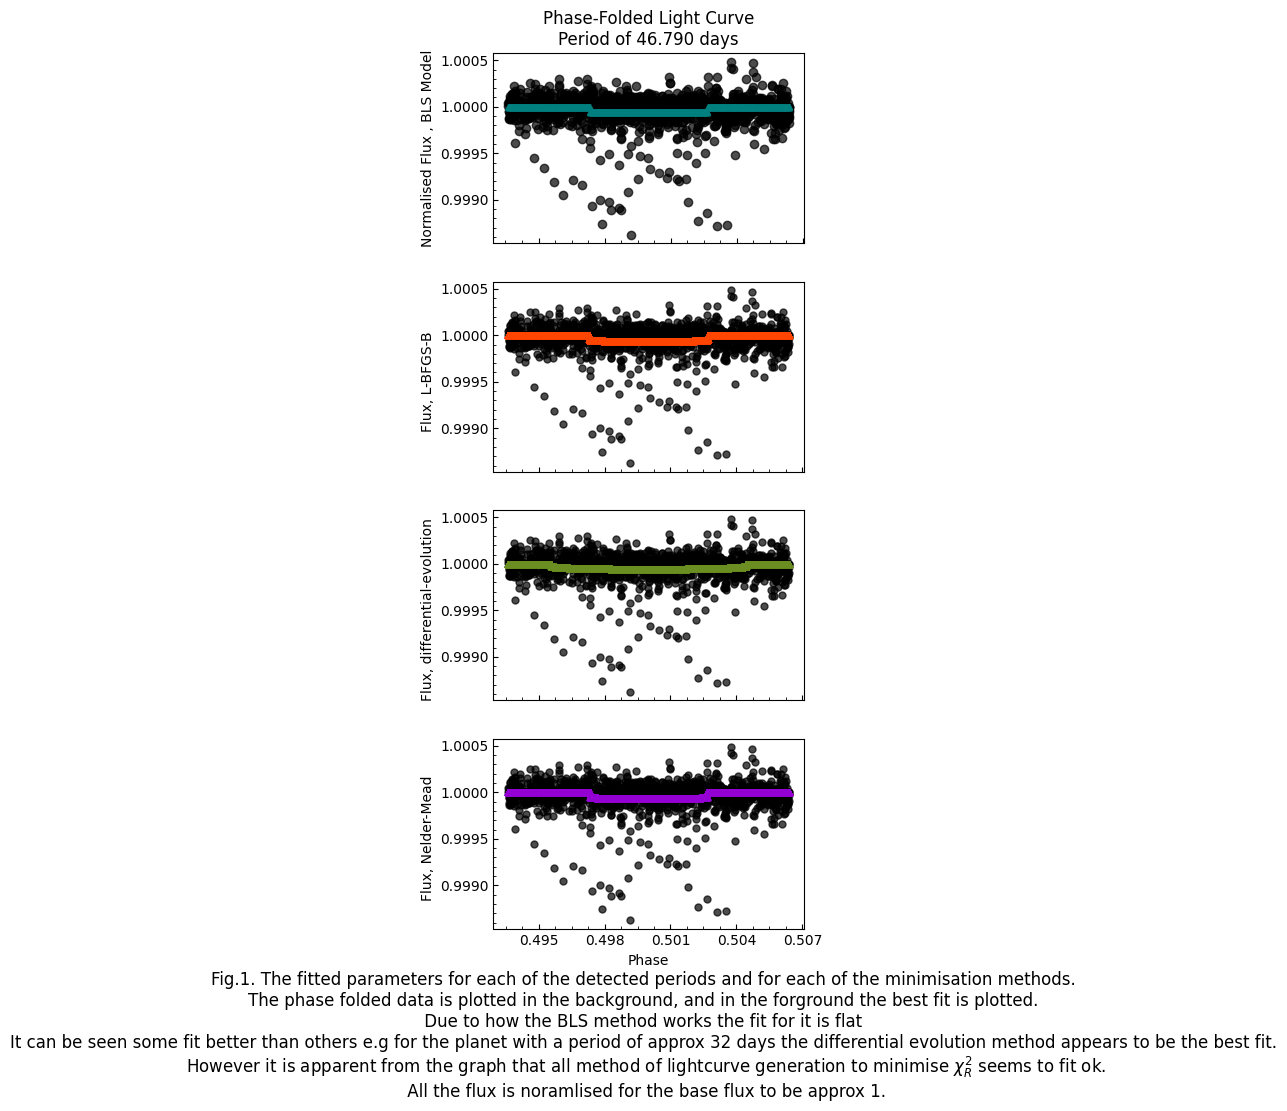

,Period (Days),Semi-major Axis (au),Radius of the Exoplanet (Solar Radii),Reduced Chi Squared,Best Method
0,46.79008 ± 0.00002,0.2371 ± 0.0505,0.0082 ± 0.0001,6.3987,differential-evolution


Table 1. The best fit parameters for each of the detected periods and the best reduced chi squared value and its associated method.
It is clear from this table that the differential evolution method is the best method for the majority of the periods detected.
Limb darkening Coefficient u1: 0.868 ± 0.037
Limb darkening Coefficient u2: 0.351 ± 0.159


In [84]:
tff.plot_phase_folded_light_curves(best_fit_results)
tff.print_best_fit_parameters(best_fit_results,bls_analysis_results)

<h2 align='center'> 3. Analysis of the Results and Discussion</h2>
</br>
<h3 align="center"> 3.1. Analysis of the Results </h3>

The results form the model fitting can be found in table.1, one result in particular is the coefficients found for the limb darkening coefficients. The value of $u_1$ of 0.876 ± 0.061 seems to lie wihtin the uncertainites matching the typical value used by Hestroffer, D. and Magnan, C. (1998), and $u_2$ is found to be 0.366 ± 0.159. 

The reduced $\chi_R^2$ sorces with most $\approx$ 2 seem to indicate a good fit considering the length of the input. It is also clear that the differntial evolution method is the best method of minimising $\chi_R^2$ for fitting the synthetic light curve to the data set.

</br>
<h3 align="center"> 3.2. Generating Synthetic Dataset </h3>

##### 3.2.1 Lightcurve Generation 

A synthetic dataset has been generated to allow for training of the neural networks, scripting for it can be found in X, it creates a lightcurves for a system by varing the following properties for each planet in the system
Orbital Period, in days
   $$
   P \sim \text{Rand}(1, 50).
   $$
Radius of the planet in solar radii
   $$
   R_{p,star} \sim \text{Rand}(0.01, 0.04),
   $$ 
The transit depth is then calculated to be
$$
   \delta =  \left(\frac{R_{p,solar}}{R_{star,solar}}\right) ^ 2 = R_{p,solar}^2 ,
$$
as $R_{star,solar}$ is assumed to be 1. 
\nThe semi-major axis can be caLculated from the period using Keplers 3rd law, and has a small pertubation applied to increase the variations in the dataset, which is inforced by the multiplication by the random number between 0.75 and 1.25.
   $$
   a = P_{earth years}^{\frac{2}{3}} * \text{Rand}(0.75, 1.25)
   $$
Where $\alpha$ is the semi-major axis, and $P_{earth years}$ is the period in terms of earth years.

The generator allows for the inclination to be set to any value, but edge on detection is assumed. it sets the inclination to be 
   $$
   i = \frac{\pi}{2}
   $$
This is due to the increase in computational time needed to model in a 3d plane, this is something that can be varied in future iterations as a further parameter. 
The transit midpoint, t_0, is defined as,
   $$
   t_0 \sim \text{Rand}(0, P).
   $$
And the limb darked coefficents are defined as,
   $$
   u1 = \text{Rand} (0.8,0.9),
   u2 = \text{Rand} (0.25,0.45).
   $$

#### 3.2.2 Position Calculations

Due to assuming edge on transits the z-direction is negligable, the distance from the star in the x and y direction can be computed as

$$ 
   x = \alpha \cos{\theta},
   y = \alpha \sin{\theta},
$$

Where the orbit angle is defined as,

$$
 \theta  = 2 \pi \frac {t + t_0}{period}.
$$

#### 3.2.3 Light curve calculations

The position calculations allow the determination of if a planet is in a transit.
The model simulates an observer on the y axis with a large positive x value.
A full transit is defined as, 
$$ 
   \text{Full Transit} = \left| y  \right| < \left( R_{star,au} - R_{planet,au} \right) 
$$
With a partial transit defined as,
$$ 
   \text{Partial Transit} = \left( R_{star,au} - R_{p,au} \right) < \left| y \right| < \left( R_{star,au} + R_{planet,au} \right) 
$$
With an extra condition in place to ensure a transit is not being recored when the planet is behind the star from the observers point of view.
$$ 
   \text{Infront of star} = x_{\text{orbit}} > 0.
$$
The intensity is determined based off the limb darkening as seen in section 1.3 of this report. Then the flux when a transit dips in full transit is modelled as,

$$
   \delta = \left(\frac{R_{p,solar}}{R_{star,solar}}\right)^2
$$

While in a partial transit, the transit depth is modified as follows


$$
   \Delta = \delta \frac{(R_{star,au} + R_P - |y|)}{R_{star,au}}
$$
The complete light curve for the system with multiple planets is obtained by adding the light curves of all individual planets.
It is calcualted as follows,
$$
F_{complete} = \frac{1}{N}\sum_{i=1}^{N} F_{i},
$$

Where $F_i$ is defined as 
$$
   F_i =
\begin{cases} 
1 - \Delta I & \text{if } Partial Transit \\
1 - \delta I& \text{if } Full Transit
\end{cases} 
$$


</br>
<h3 align="center"> 3.3. The Neural Networks </h3>

Two types of neural network have been developed, a convolutional neural network, and a recurrant neural network. 

The neural networks can use the synthetic light curve model as training data to train for planet count and period prediction. The proposed input of the training data will be the lightcurve, along with the period count of the number of detectable exoplanets. As shown in Kipping, D. (2023) exoplanets transiting have a SNR of

$$
   SNR =  \frac{\delta}{\sigma_{std}} \sqrt{\phi},
$$

where $\delta$ is the transit depth, $\sigma{std}$ is the standard deviation of the flux of the lightcurve, and $\phi$ is the number of transit that occurs during the timeframe. This is used to apply a threshold of detectable planets. This will be done in an early effort to prevent overfitting and avoid training the model to detect physicsally undetectable planets. The threshold can be vaired depending on the acceptable rate of false positives, A value of 5 was chosen for this model.  

#### 3.3.1 The Loss Function

The loss function evaluates the difference between the predicted output and the actual output. It has been defined as 

$$
Loss = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{1}{M_i} \sum_{j=1}^{M_i} (T_{ij} - P_{ij})^2 \right) + \frac{1}{N} \frac{\tilde{P}}{\tilde{M}}\sum_{i=1}^{N} (M_i - m_i)^2 \\
$$

The subscript $i$ denotes the $i^{th}$ lightcurve in the batch, and $j$ is THE $j^{th}$ detectable planet in the lightcurve, $M_i$ is the number of detectable periods at index $i$, $T_{ij}$ is the predicted period and $P_{ij} is the actual period. $m_i$ is the predicted amount of planets and $N$ is defined as

$$
N = \text{batch size} * \text{length of input}.
$$

The term 

$$
   \frac{\tilde{P}}{\tilde{M}}
$$

Is used to scale the loss in planet prediction to be similar in scale to the loss in the period prediction, the $~$ represents the average value.
The parameters of the model have been tuned to allow computational efficency, however due to the size of the lightcurves GPU memeory provides a significant bottleneck. The model present in this report has been trained on an RTX 2070 super with 8Gb of vram, training on a large cluster or a GPU with a larger memory would lead to more opportunites for complexity to be added to the model. 

A learning weight of $1e^{-4}$ and weight decay of $1e^{-5}$ was chosen for both models. A graph detailing the loss of the provided models can be found in the appendix.

#### 3.3.2 Overfitting 

Overfitting in the CNN model is the reason a RNN model was also developed. Due to the size of the convolution layers in comparison to the size of a lightcuvre it lead to the output of the model having little variation depending on the input. The CNN model found the amount of planets to be approximaley 5,and would approximate all periods to be 25, these are the average of both of these inputs. This is known as a local minimia, where both of these values are consistently 'good enough'. The large dropout layer is the protection against this local minimun. This layer ignores 30% of the weights for each calculation, it forces the network to not become reliant on specific neurons and encouranges the network to distribute the information across many neurons making the network more robust. However even this large dropout layer had minimial effect at reducing this issue.

Furtuthermore due to the RNN being developed after the CNN I have added a layer of recursion where if the periods are too close the model gets punished and a random value is generated for some of the periods instead, this works much better than it should.

#### 3.3.3 Demonstration of the Model 

In The code block below a random lightcurve is generated using the syntehtic lightcurve deveveloped as part of this report, this lightcurve is fed to the neural networks which both make a prediction. It can be seen in table 2 and 3 that sometimes the model is close, but this is still far beyond any practial applications of the model. But it does serve as a proof of concept

#### 3.3.4 The Model evaulted on the Unkown Kepler System 

The synthetic data has been generated to be comparable to the provided dataset, in table 4 and 5 below it can be seen that the model struggles to predict accurate periods.



$$
\begin{array}{cc}
\text{\textbf{CNN Model}} & \text{\textbf{RNN Model}} \\
\\
\\
\begin{array}{c}
\text{Lightcurve} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Convolutional Layer} \\
\text{Conv1d:} \\
\text{Input: 1 channel} \\
\text{Output:16 channels} \\
\text{Kernel Size: 5} \\
\text{Padding: 2} \\
\hline
\end{array} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Convolutional Layer} \\
\text{Conv1d:} \\
\text{Input: 16 channels} \\
\text{Output: 32 channels} \\
\text{Kernel Size: 5} \\
\text{Padding: 2} \\
\hline
\end{array} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Convolutional Layer} \\
\text{Conv1d:} \\
\text{Input: 32 channels} \\
\text{Output: 64 channels} \\
\text{Kernel Size: 5} \\
\text{Padding: 2} \\
\hline
\end{array} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Max Pooling Layer} \\
\text{MaxPool1d:} \\
\text{Kernel Size: 2} \\
\hline
\end{array} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Fully Connected Layer} \\
\text{Linear:} \\
\text{Input: 128 * 39151} \\
\text{Output: 128} \\
\hline
\end{array} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Dropout Layer} \\
\text{Dropout:} \\
\text{Probability: 0.3} \\
\hline
\end{array} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Fully Connected Layer} \\
\text{Linear:} \\
\text{Input: 128} \\
\text{Output: 1} \\
\hline
\end{array} \\
\downarrow \\
\text{Predicted Number of Planets (scaled to 0-10)} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Fully Connected Layer} \\
\text{Linear:} \\
\text{Input: 128} \\
\text{Output: 10} \\
\hline
\end{array} \\
\downarrow \\
\text{Predicted Periods (up to 10)} 
\end{array} &
\begin{array}{c}
\text{Lightcurve} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{RNN Layer} \\
\text{RNN:} \\
\text{Input: 1 channel} \\
\text{Output: 1024 channels} \\
\text{Layers: 2} \\
\text{Dropout: 0.3} \\
\hline
\end{array} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Fully Connected Layer} \\
\text{BayesianDense:} \\
\text{Input: 1024} \\
\text{Output: 1} \\
\text{Dropout: 0.3} \\
\hline
\end{array} \\
\downarrow \\
\text{Predicted Number of Planets (scaled to 0-5)} \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Fully Connected Layer} \\
\text{BayesianDense:} \\
\text{Input: 1024} \\
\text{Output: 1} \\
\text{Dropout: 0.3} \\
\hline
\end{array} \\
\downarrow \\
\text{Predicted Periods (up to 5), Max Period of 50 } \\
\downarrow \\
\begin{array}{|c|}
\hline
\text{Checks to ensure periods are not too close:} \\
\text{If periods are too close, some of the periods are randomised} \\
\text{This punishes the model for guessing periods too close together} \\
\text{It gives a high loss when this occurs and discourages it from happening again} \\
\hline
\end{array}
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\\
\end{array}
\end{array}
$$

</br>
<p align='center'><b>Fig2.</b> The architecture of the CNN model, and the RNN model provided as part of this report.</p>

/home/omcevoy/AstroCourseworkBPaper/RNN.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)
/home/omcevoy/AstroCoursewor

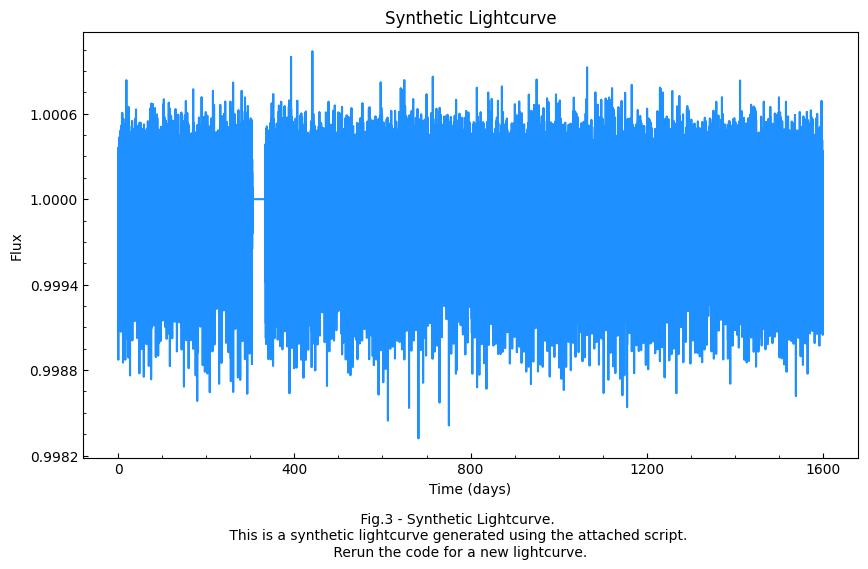

,Model,Actual Period (Days),Predicted Period (Days)
0,RNN_Synth,17.324,1.249
1,RNN_Synth,20.779,9.979
2,RNN_Synth,5.325,27.072
3,CNN_Synth,17.324,24.907
4,CNN_Synth,20.779,22.871
5,CNN_Synth,5.325,24.723


Table 2. Comparison of Actual and Predicted Periods for Synthetic Data



,Model,Actual Number of Planets,Predicted Number of Planets
0,RNN_Synth,3,2.930
1,CNN_Synth,3,2.611


Table 3. Comparison of Actual and Predicted Number of Planets for Synthetic Data



,Model,Actual Period,Predicted Period
0,RNN_Real,36.124,1.249
1,RNN_Real,nan,9.136
2,RNN_Real,nan,46.639
3,CNN_Real,36.124,24.906
4,CNN_Real,nan,22.870
5,CNN_Real,nan,24.722


Table 4. Comparison of Actual and Predicted Periods for Real Data



,Model,Actual Number of Planets (Days),Predicted Number of Planets (Days)
0,RNN_Real,4,2.930
1,CNN_Real,4,2.611


Table 5. Comparison of Actual and Predicted Number of Planets for Real Data


In [78]:
ml_results = {}

RNN_model_path = 'Models/RnnModel.pth'
CNN_model_path = 'Models/CnnModel.pth'
max_planets_in_system = 5


ml_results['RNN_Synth'],ml_results['CNN_Synth'] = ml_prediction.main(model_path=RNN_model_path,model_name='both',comparison_model_path=CNN_model_path,generate_light_curve=True, max_planets_in_system=max_planets_in_system)
ml_results['RNN_Real'],ml_results['CNN_Real'] = ml_prediction.main(model_path=RNN_model_path,model_name='both',comparison_model_path=CNN_model_path,generate_light_curve=False, max_planets_in_system=max_planets_in_system)

ml_prediction.print_comparison_results(ml_results,bls_analysis_results)


Analyzing Periods: 100%|██████████| 9/9 [00:00<00:00, 41345.82it/s]


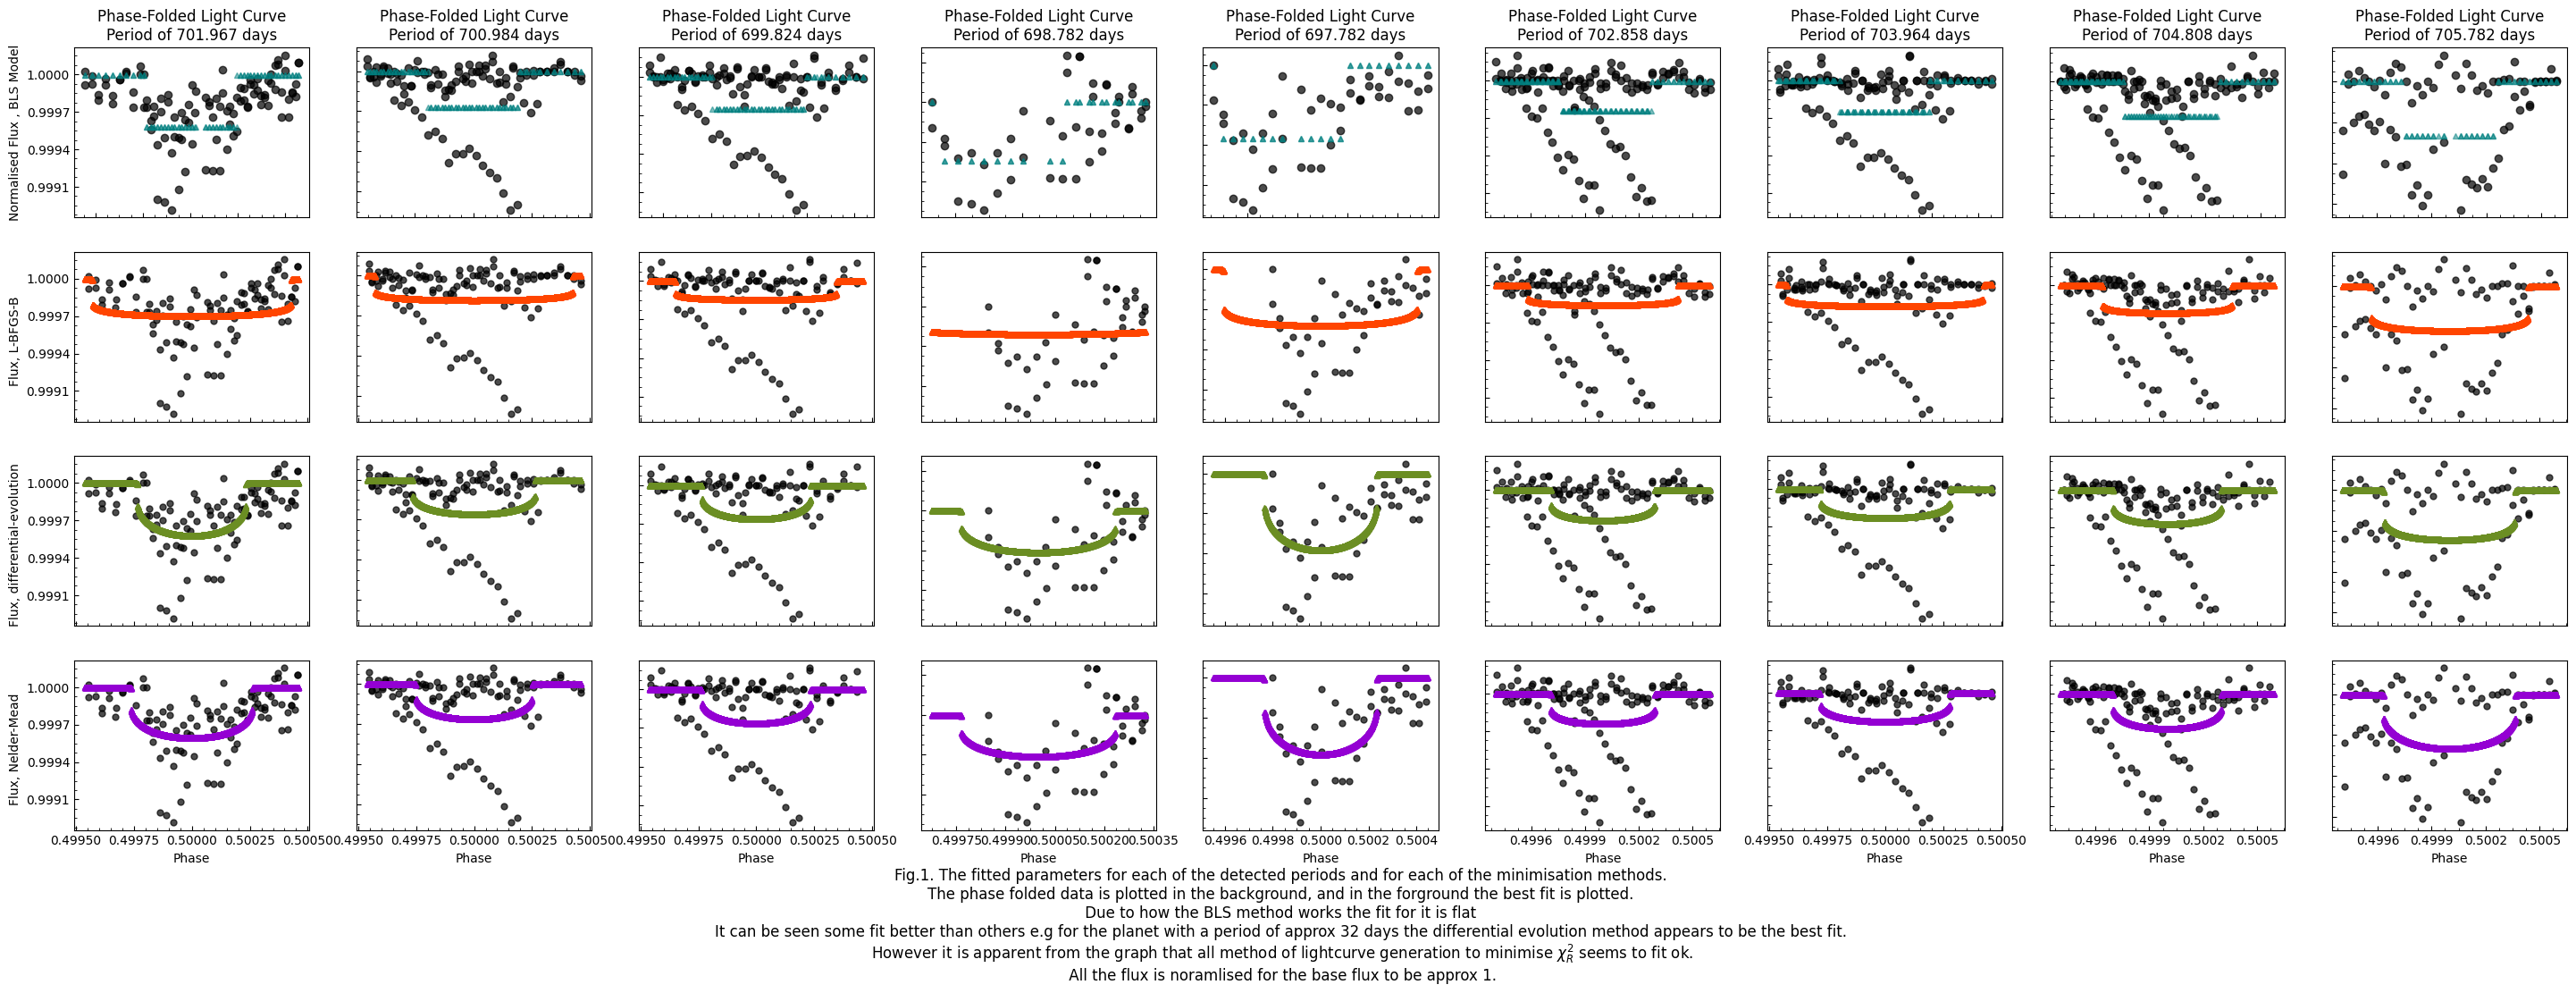

,Period (Days),Semi-major Axis (au),Radius of the Exoplanet (Solar Radii),Reduced Chi Squared,Best Method
0,701.96655 ± 0.00000,2.5204 ± 0.5958,0.0213 ± 0.0022,10.0486,differential-evolution
1,700.98352 ± 0.00000,2.4453 ± 0.5271,0.0194 ± 0.0021,22.9129,differential-evolution
2,699.82352 ± 0.00000,2.7572 ± 0.4660,0.0189 ± 0.0031,24.7448,differential-evolution
3,698.78217 ± 0.00000,2.5925 ± 0.6945,0.0213 ± 0.0025,29.7596,differential-evolution
4,697.78232 ± 0.00000,2.6514 ± 0.6072,0.0253 ± 0.0026,13.6415,differential-evolution
5,702.85791 ± 0.00000,2.2487 ± 0.3619,0.0182 ± 0.0021,25.9378,differential-evolution
6,703.96352 ± 0.00000,2.3200 ± 0.4191,0.0182 ± 0.0017,25.4621,differential-evolution
7,704.80791 ± 0.00000,2.2799 ± 0.1804,0.0201 ± 0.0016,23.9614,differential-evolution
8,705.78190 ± 0.00000,1.8727 ± 0.1521,0.0239 ± 0.0016,39.0766,differential-evolution


Table 1. The best fit parameters for each of the detected periods and the best reduced chi squared value and its associated method.
It is clear from this table that the differential evolution method is the best method for the majority of the periods detected.
Limb darkening Coefficient u1: 0.926 ± 0.032
Limb darkening Coefficient u2: 0.444 ± 0.153


In [129]:

#peaks = [46.79,46.79*5,46.79*10 ,46.79*15,46.79*20]
peaks = [701.887,701.887-1,701.887-2,701.887-3,701.887-4,701.887+1,701.887+2,701.887+3,701.887+4]
#allowed deviated was 0.005 to find the multiple of 6 days peak  
allowed_deviation = 0.00015

import importlib
importlib.reload(tff)

#When a higher resolution is used, there is less of an overlap of peaks, however incase a lower resolution is used, the function below can be used to remove duplicates.
#peaks_of_lightcurve_filter_duplicates = tff.remove_exact_duplicates(peaks,0.05, False)
bls_analysis_results = tff.analyze_peaks_with_bls(
      kepler_dataframe,
      peaks,
      duration_range=(0.1, 0.35),
      resolution=80000,
      allowed_deviation=allowed_deviation,
      n_bootstrap=number_of_bootstrap_iterations_for_uncertainties,
      bootstrap_resolution=bootstrap_resolution
)

methods = ['Nelder-Mead','L-BFGS-B','differential-evolution']

best_fit_results = tff.calculate_best_fit_parameters(
    kepler_dataframe,
    bls_analysis_results,
    L_BFGS_B_options =L_BFGS_B_options ,
    nelder_mead_options=nelder_mead_options,
    differential_options=differential_options,
    methods=methods,
    cadence=cadence
)

tff.plot_phase_folded_light_curves(best_fit_results)
tff.print_best_fit_parameters(best_fit_results,bls_analysis_results)

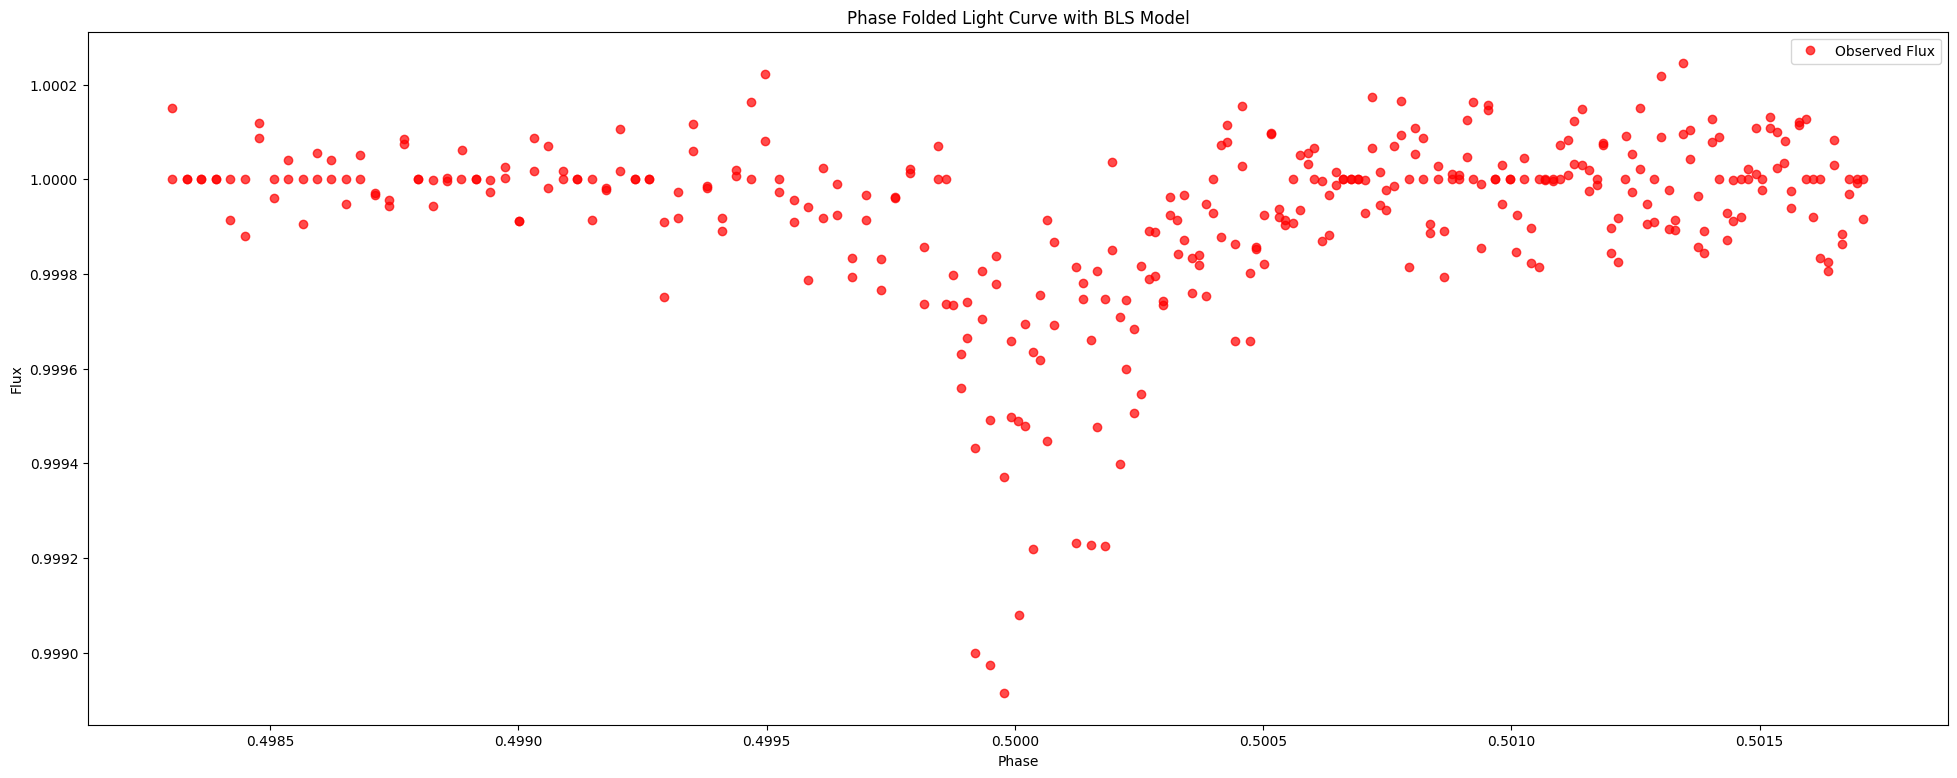

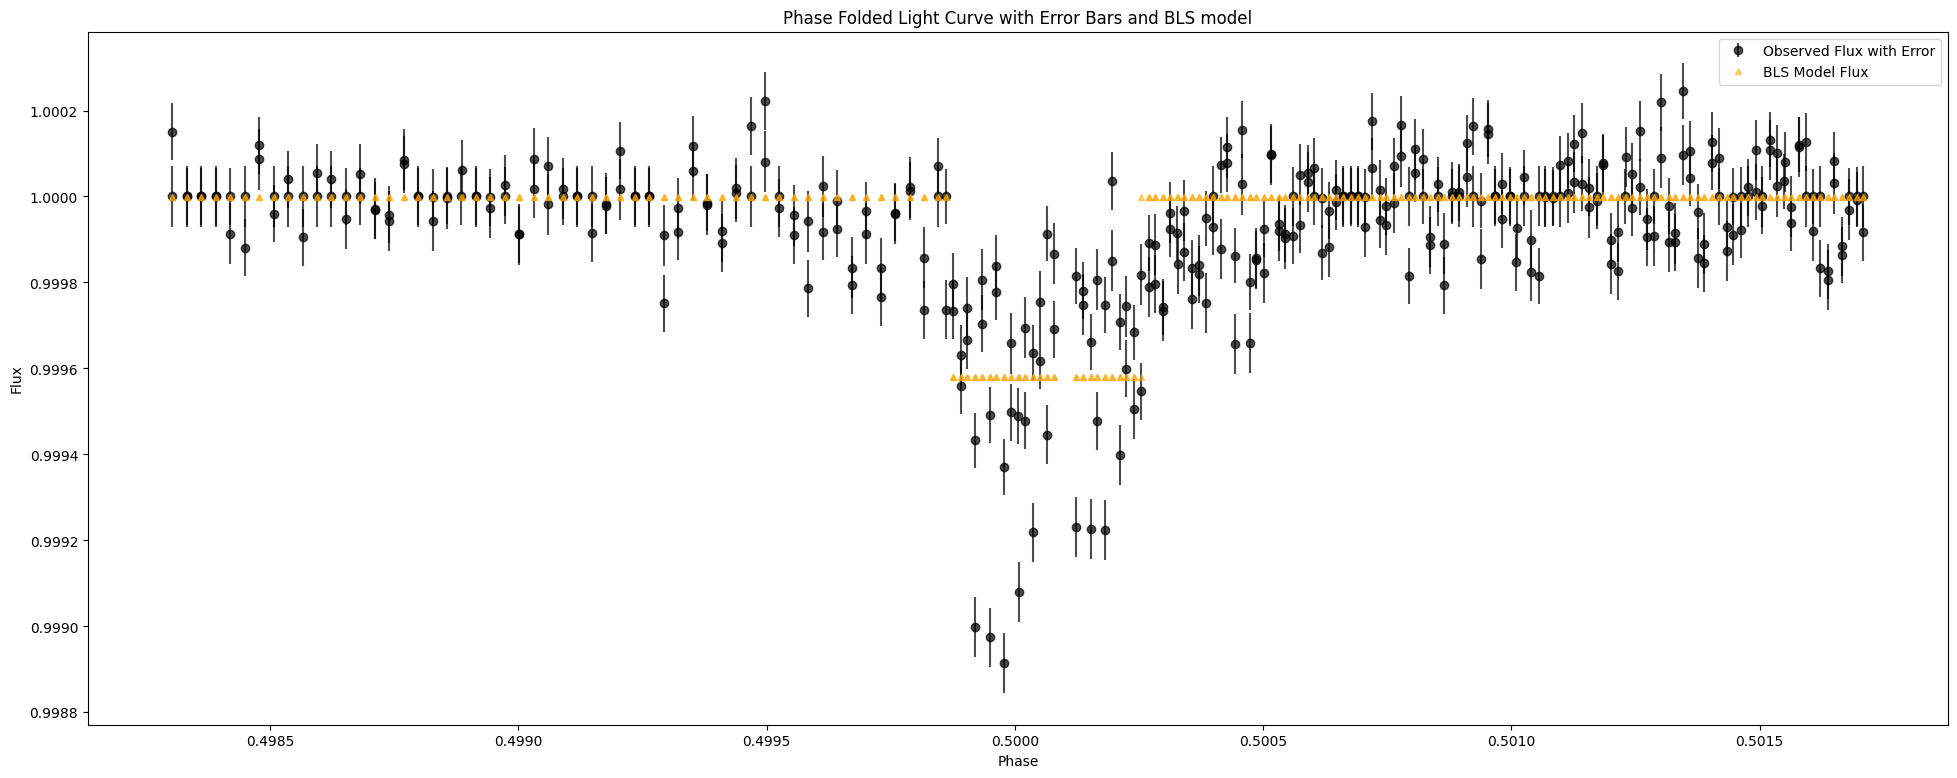

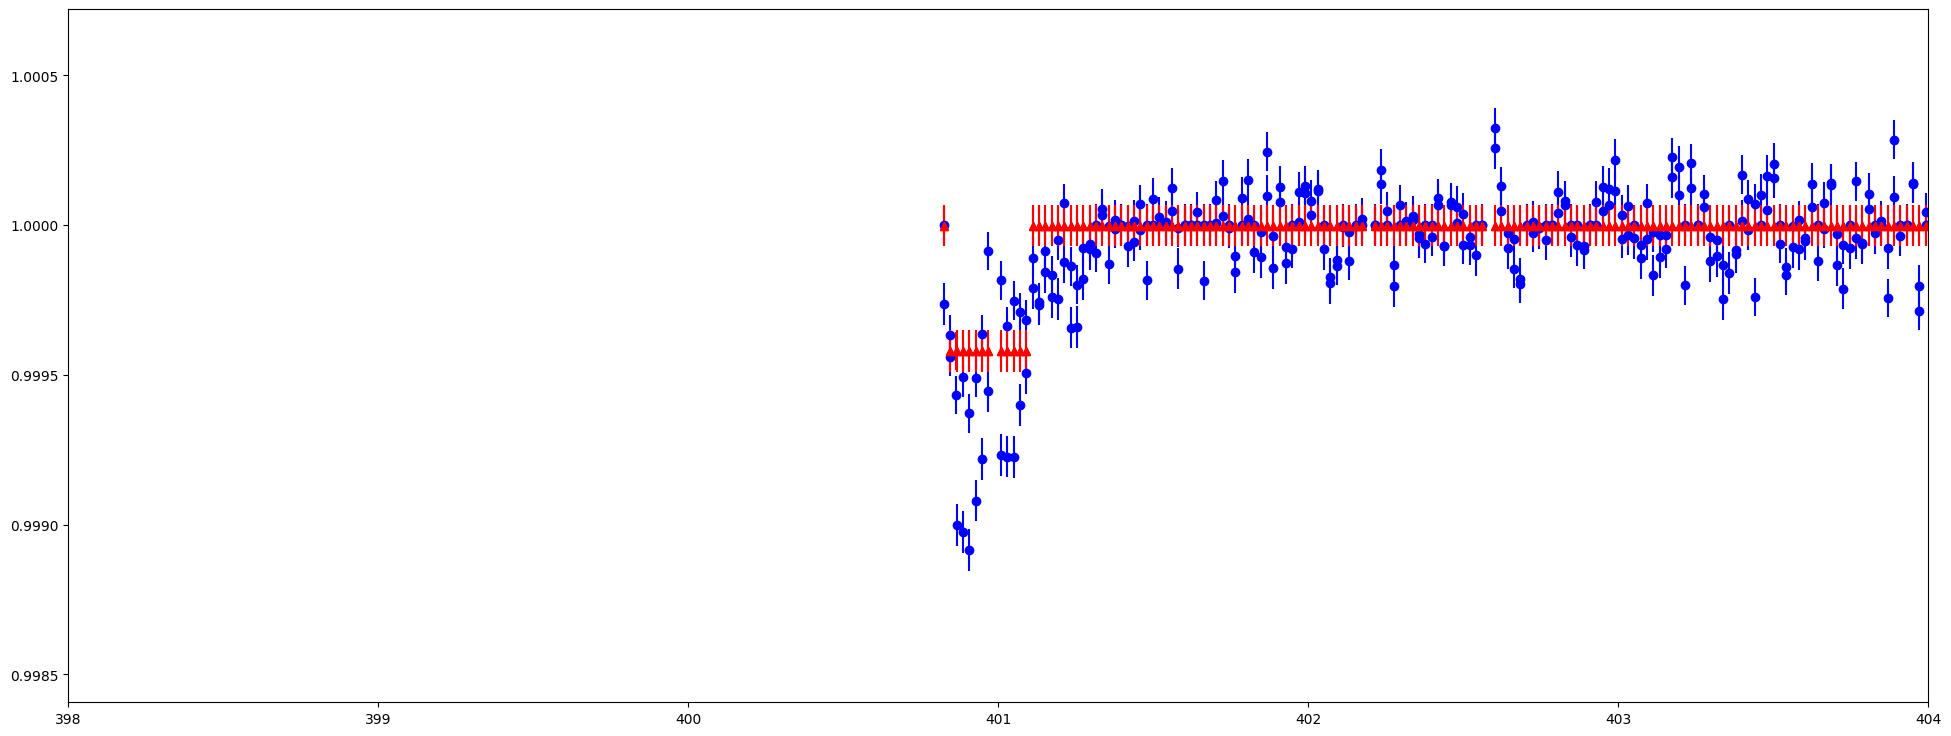

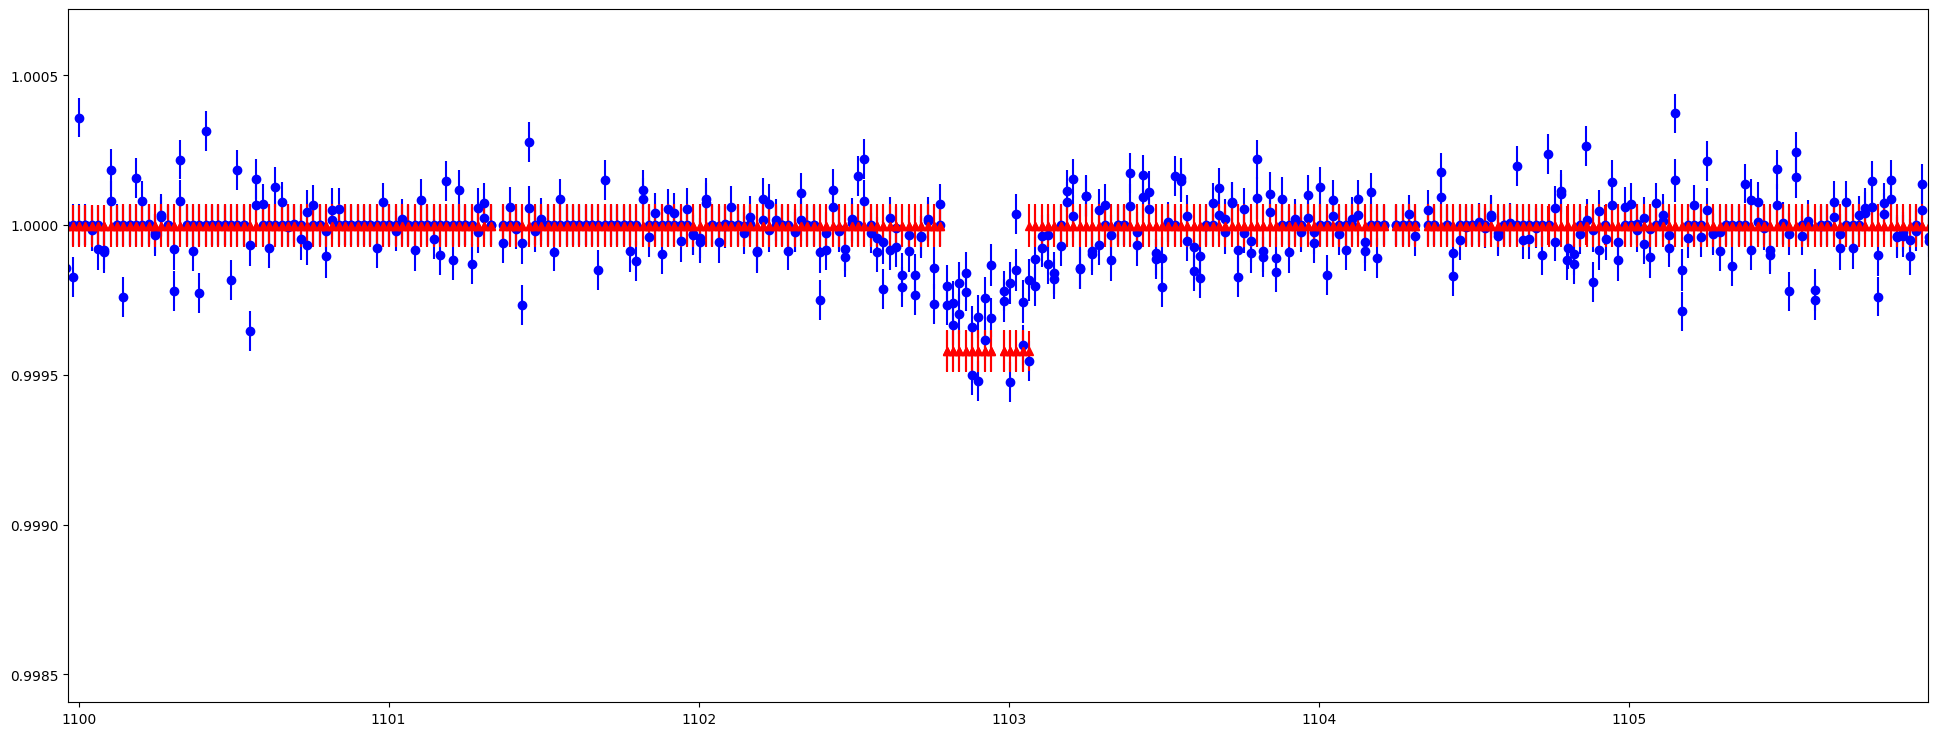

In [185]:
import importlib
importlib.reload(tff)
import matplotlib.pyplot as plt

#get the first half of the dataframe and plot the lightcurve

result = best_fit_results[0][0]

tff.phase_fold_light_curve_and_plot(701.96655,kepler_dataframe['time'],kepler_dataframe['flux'],1,result["bls_model_flux"],-0.49645,kepler_dataframe['error'])


transit_midpoint = 401
view_size = 3

#plot on kepler graph
fig, ax = plt.subplots(1, 1, figsize=(24, 9))
plt.errorbar(kepler_dataframe['time'],kepler_dataframe['flux'],label='Kepler Data',yerr=kepler_dataframe['error'],color='blue',marker='o',linestyle='None')
plt.errorbar(kepler_dataframe['time'],result["bls_model_flux"],label='BLS Model',yerr=kepler_dataframe['error'],color='red',marker='^',linestyle='None')

plt.xlim(transit_midpoint-view_size,transit_midpoint+view_size)
plt.show()

transit_midpoint = transit_midpoint + 701.96655
#plot on kepler graph
fig, ax = plt.subplots(1, 1, figsize=(24, 9))
plt.errorbar(kepler_dataframe['time'],kepler_dataframe['flux'],label='Kepler Data',yerr=kepler_dataframe['error'],color='blue',marker='o',linestyle='None')
plt.errorbar(kepler_dataframe['time'],result["bls_model_flux"],label='BLS Model',yerr=kepler_dataframe['error'],color='red',marker='^',linestyle='None')

plt.xlim(transit_midpoint-view_size,transit_midpoint+view_size)
plt.show()



In [131]:
import importlib
importlib.reload(tff)


for i in range(1,36):
    peaks = [46.79*i] 
    allowed_deviation = 0.001/i

    #When a higher resolution is used, there is less of an overlap of peaks, however incase a lower resolution is used, the function below can be used to remove duplicates.
    #peaks_of_lightcurve_filter_duplicates = tff.remove_exact_duplicates(peaks,0.05, False)
    bls_analysis_results = tff.analyze_peaks_with_bls(
        kepler_dataframe,
        peaks,
        duration_range=(0.2, 0.4),
        resolution=20000,
        allowed_deviation=allowed_deviation,
        n_bootstrap=number_of_bootstrap_iterations_for_uncertainties,
        bootstrap_resolution=bootstrap_resolution
    )

    #methods = ["differential-evolution"]
    methods = ['Nelder-Mead','L-BFGS-B','differential-evolution']

    best_fit_results = tff.calculate_best_fit_parameters(
        kepler_dataframe,
        bls_analysis_results,
        L_BFGS_B_options =L_BFGS_B_options ,
        nelder_mead_options=nelder_mead_options,
        differential_options=differential_options,
        methods=methods,
        cadence=cadence
    )

    tff.plot_phase_folded_light_curves(best_fit_results)
    tff.print_best_fit_parameters(best_fit_results,bls_analysis_results)

Analyzing Periods: 100%|██████████| 1/1 [00:00<00:00, 13617.87it/s]


KeyboardInterrupt: 

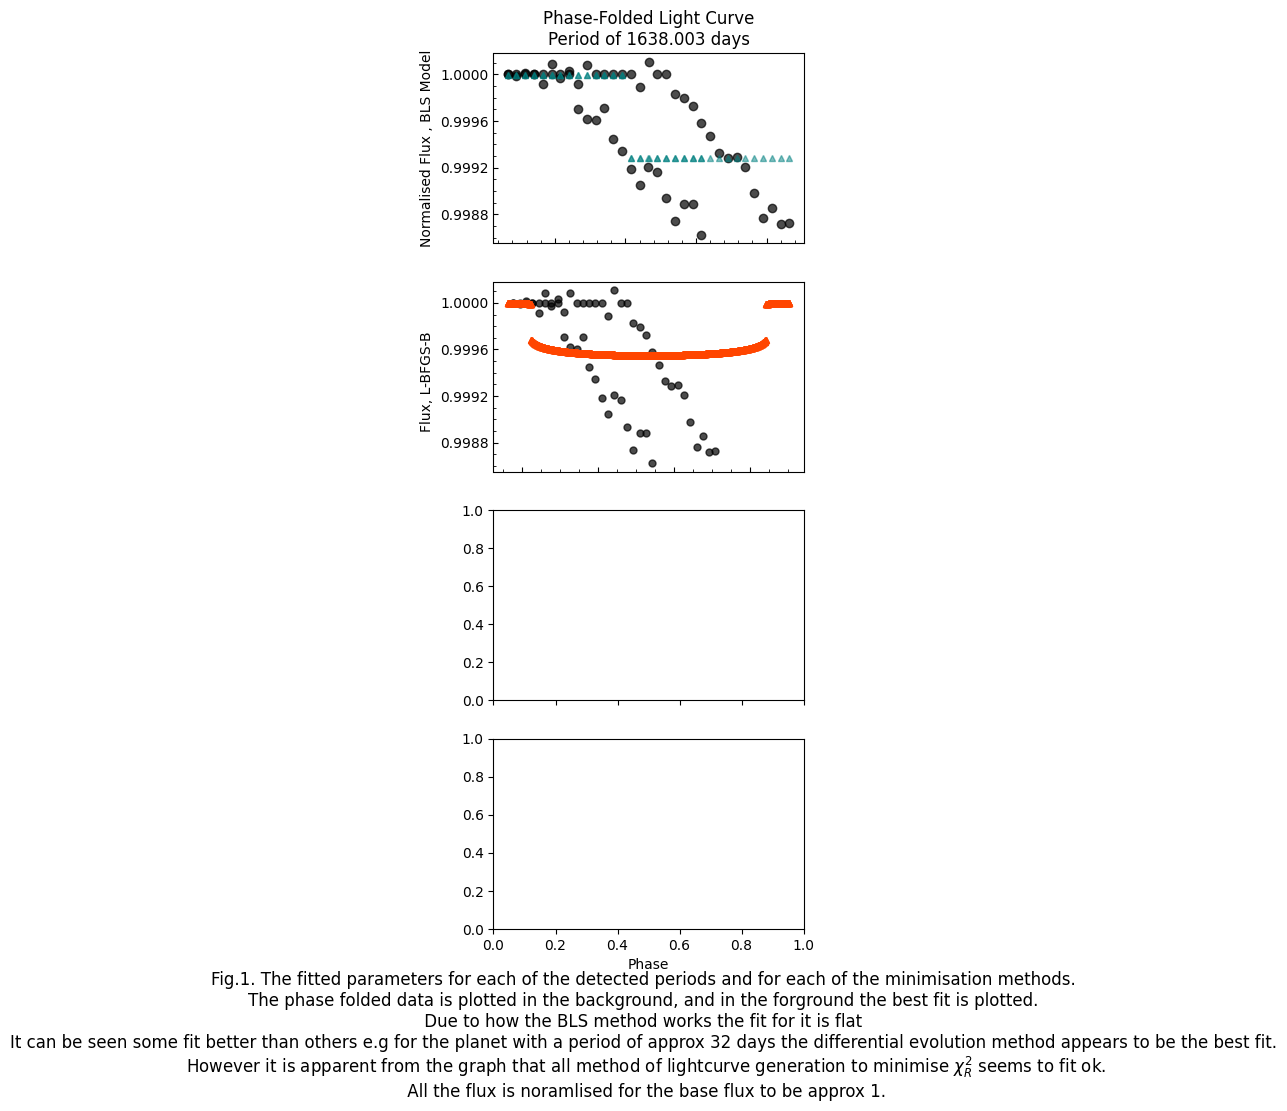

,Period (Days),Semi-major Axis (au),Radius of the Exoplanet (Solar Radii),Reduced Chi Squared,Best Method
0,1634.60321 ± 0.00000,3.1219 ± 0.0000,0.0223 ± 0.0000,42.4684,Nelder-Mead


Table 1. The best fit parameters for each of the detected periods and the best reduced chi squared value and its associated method.
It is clear from this table that the differential evolution method is the best method for the majority of the periods detected.
Limb darkening Coefficient u1: 0.859 ± 0.000
Limb darkening Coefficient u2: 0.263 ± 0.000


In [ ]:
importlib.reload(tff)
tff.plot_phase_folded_light_curves(best_fit_results,0.4)
tff.print_best_fit_parameters(best_fit_results,bls_analysis_results,-3)

<h3 align = 'center'> 3.4. Future Improvements and Observations </h3>

#### 3.4.1 Fine-tune on the Kepler Dataset

Fine tuning the model by using the Kepler dataset and known planet transits could help the model deal with phenomons unique to real data that cannot be accurately represented by synthetic data. However, considerations will need to be made. for example, the Kepler dataset lightcurves will have to be truncated or extended. Its hypothesised a variable input or padding could be used but the best data however this is not proven for planet tranasit yet. But this is an area that could be quite benefitial to be explored further. 

But for the premise of detecting the unkown system better, observations of similar systems would provide most benefitial for fine tuned training data.

Less noisy data would also be desired it is hoped this will aid the model to find the exoplanets of a lower period, something is is currently struglling with. Also this would also aid in traditional methods of finding exoplanets which could lead us to find more exoplanets in the system that are currently difficult to find due to the noise in the .

#### 3.4.2 High Powered Computing Time

The inital planned architecture of the model has been heavily scaled back due to memeory limitations, in particular the CNN model.
This model has been trained on a NVIDA RTX 2070s 8GB, a larger GPU or even a GPU cluster would allow for more epochs, larger batches, more training data and oppertunties for a more complex architecture. While it is debateable if a more advanced model will always be better, it is my belief that due to the scale of the input, larger layers would signidicant increase the acccuracy of this model. For the demonstation of the syntehtic lightcurve generator 400,000 light curves have been generated, however less than 5% of this has been used to train the models present in the report. 

<h2 align = 'center'> 4. Summary </h2>

Machine learning models provide another tool in the arsonal of exoplanet detection, but for an accurate model to be made more computation time is needed due to the sheer scale of the size of the inputs. Moore's law is not dead yet and with the active focus in this field it is not unrealistic to assume eventually a model could be produced identifing exoplanets in an unknown system. 

But this does beg the question is a machine learning model really the best approach to detecting exoplanets? The amount of time spent on using traditonal methods with high percision is dwarfed by the development time and compute time spent on creating a model to identify the periods of these planets. Traditonal methods with found 4 planets, results from which can be seen in table 1. The RNN and CNN model results for the unkown system can be seen in table 4 and table 5. The CNN does a bad job, however the RNN predicts an exoplanet with period of 30.603 days and 45.611 days, this is not too dissimilar to the actual periods found and serves as encouragement that future research in this field is benefitial.



### References:

- Shallue, C.J. and Vanderburg, A. (2017) 'Identifying exoplanets with deep learning: A five planet resonant chain around Kepler-80 and an eighth planet around Kepler-90'
- Hestroffer, D. and Magnan, C. (1998) 'Wavelength dependency of the Solar limb darkening', Astronomy and Astrophysics, 333, pp. 338-342.
- Kipping, D. (2023) 'The SNR of a transit', Monthly Notices of the Royal Astronomical Society, 523(1), pp. 1182-1191
- Barbara, N.H., Bedding, T.R., Fulcher, B.D., Murphy, S.J. and Van Reeth, T. (2022) 'Classifying Kepler light curves for 12,000 A and F stars using supervised feature-based machine learning', Monthly Notices of the Royal Astronomical Society, 514(2), pp. 2793-2804
- Foreman-Mackey, D., (2021). exoplanet: Probabilistic Modeling of Transit and Radial Velocity Observations. Version 0.5.1. Available at: https://github.com/exoplanet-dev/exoplanet
- Zhu, C., Byrd, R.H., Lu, P. and Nocedal, J., (1997). Algorithm 778: L-BFGS-B: Fortran Subroutines for Large-Scale Bound-Constrained Optimization. ACM Transactions on Mathematical Software (TOMS), 23(4), pp.550-560.
- Storn, R. and Price, K., 1997. Differential Evolution - a Simple and Efficient Heuristic for Global Optimization over Continuous Spaces. Journal of Global Optimization, 11, pp.341-359.
- Nelder, J.A. and Mead, R., (1965). A simplex method for function minimization. The Computer Journal, 7(4), pp.308-313.
- Espinoza, N. and Jordán, A., (2015). Limb darkening and exoplanets: testing stellar model atmospheres and identifying biases in transit parameters. Monthly Notices of the Royal Astronomical Society, 450(2), pp.1879–1899. 


### Acknowledgments

- <a href='https://numpy.org'> NumPy </a>
- <a href='https://www.scipy.org'> SciPy </a>
- <a href='https://matplotlib.org'> Matplotlib </a>
- <a href='https://pandas.pydata.org'> Pandas </a>
- <a href='https://www.astropy.org'> AstroPy </a>
- <a href='https://pytorch.org'> PyTorch </a>

In [101]:
!jupyter nbconvert --to html --no-input Coursework_B_24474.ipynb

[NbConvertApp] WARNING | pattern 'Coursework_B_24474.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exec

<h2 align='center'>  5. Appendix <h2>

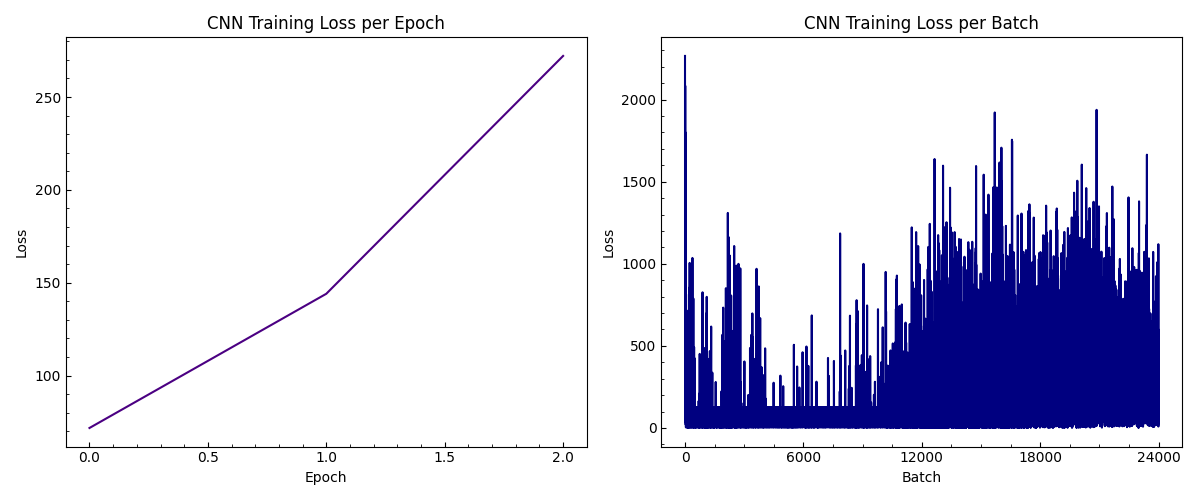

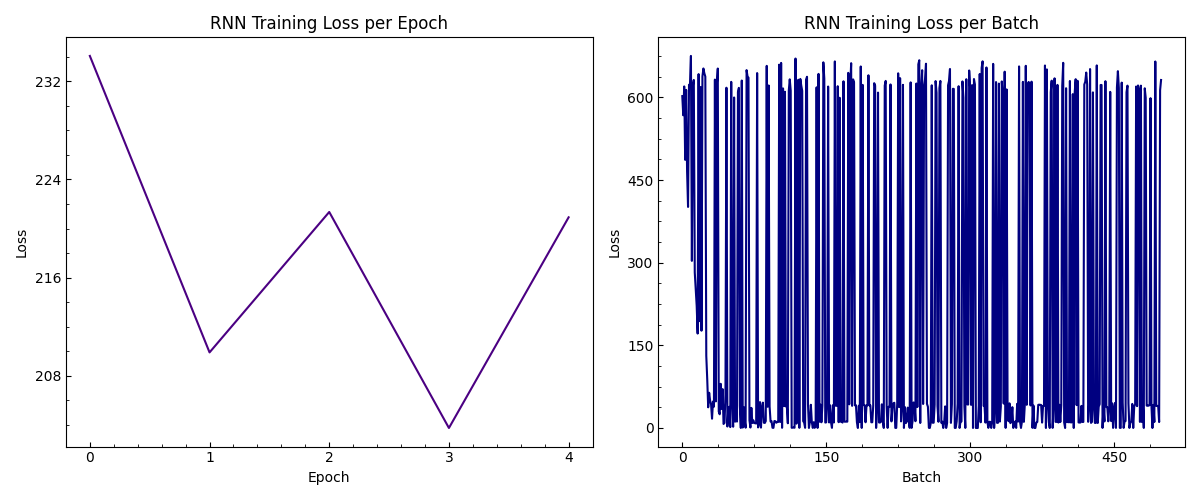

In [102]:
#Note the CNN intiially falls into a local minima, but after a few epochs it starts to improve. but its still a bit rubbish espeically compared to the RNN.
display(Image(filename='Images/CnnLoss.png'))
display(Image(filename='Images/RnnLoss.png'))